# 3. GAN

2장에서는 Victorain400 데이터셋의 이미지를 폴더별로 시각화 해보았습니다. 3장에서는 본격적으로 GAN을 이용하여 흑백 이미지를 컬러 이미지로 변환시키는 모델을 구축해보도록 하겠습니다.


3.1절에서는 모델링에 사용할 데이터를 불러오고, 3.2절에서는 데이터셋 클래스를 정의하여 데이터 로더까지 정의하도록 하겠습니다. 3.3절에서는 Generator 클래스와 Discriminator 클래스를 정의하여 모델을 구축해보겠습니다. 그리고 3.4절에서는 하이퍼파라미터를 설정하여 구축된 모델을 학습시킨 후, 3.5절에서 테스트 데이터에 대한 예측과 성능평가를 해보도록 하겠습니다.

## 3.1 데이터 다운로드

2.??절에서 나온 코드를 활용하여 모델에 사용할 데이터셋을 내려받도록 하겠습니다. 가짜연구소 깃허브의 Tutorial-Book-Utils를 `clone`하여 PL_data_loader.py 파일로 Victorian400 데이터셋을 내려받고 압축을 푸는 순서입니다.

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

이번에는 3장에서 사용할 패키지들을 불러오겠습니다. `numpy`는 수치 연산에 사용되는 선형 대수 패키지이며, `matplotlib`은 시각화에 사용하는 패키지입니다. `glob` 패키지는 파일 경로를 지정할 수 있고, `PIL`의 `Image` 패키지는 이미지 파일을 열 때 사용합니다. 그 외의 `torch`와 `torchvision` 패키지는 데이터셋 정의와 모델 구축에 사용되는 Torch 기반의 패키지들입니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## 3.2 데이터셋 클래스 정의

파이토치 모델에 데이터를 학습하기 위해서 데이터셋 클래스를 정의해보도록 하겠습니다. 이미지 변환(transforms)과 흑백, 컬러 이미지의 폴더 경로를 인자로 받아 `Image.open` 함수를 사용하여 해당 이미지를 불러옵니다. 흑백 이미지는 `.convert("L")`을 사용하여 단일 채널로, 컬러 이미지는 `.convert("RGB")`을 사용하여 3채널로 받아줍니다. 그리고 이미지 변환을 거쳐 딕셔너리 형태로 흑백 이미지와 컬러 이미지를 "A", "B"에 각각 반환시켜줍니다.

In [3]:
class victorianDataset(Dataset):
    def __init__(self, root, transforms_=None):

        self.transform = transforms.Compose(transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
     
    def __getitem__(self, index):

        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.transform(gray_img)
        color_img = self.transform(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)


이미지 경로와 사이즈, 각 데이터셋의 배치사이즈를 지정해줍니다. 이미지 사이즈와 배치사이즈는 각자의 환경(최대 메모리 사용량)에 맞춰 설정해주면 됩니다. 단, 이후에 나올 모델 구조가 64로 고정되어 있어 다른 이미지 사이즈를 원하실 경우 모델 구조 안의 input 사이즈도 변경해주셔야 합니다.

In [4]:
root = ''
test_root = root + 'test/'

img_height = 64
img_width = 64

batch_size = 32
test_batch_size = 6

gpu = 0

데이터셋 클래스의 인자로 넣을 이미지 변환(transform)을 지정합니다. 지금은 모델에 맞는 이미지 사이즈로 `Resize`를 해주고, 파이토치 모델에 넣기 위해 tensor 타입으로 바꿔주기만 하겠습니다. 이 외에도 도메인에 따라 `RandomCrop`(랜덤으로 자르기), `RandomVerticalFlip`(랜덤으로 수평 뒤집기) 등 다양한 이미지 변형을 할 수 있습니다. 또한 `normalize`를 통해 학습의 일반화 성능을 향상시킬수 있습니다.

In [5]:
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

`DataLoader` 함수를 통해 위에서 정의한 데이터셋 클래스와 이미지 변환(transform)을 넣어 데이터 로더를 만들어줍니다. 데이터 로더가 제대로 구성되어 있는지 시각화를 통해 알아보겠습니다. "A"에 해당하는 흑백 이미지는 `imshow`함수에서 `cmap=gray`를 설정해주어야 제대로 표시할 수 있습니다.

In [6]:
train_loader = DataLoader(
    victorianDataset(root, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True
)

torch.Size([32, 1, 64, 64]) torch.Size([32, 3, 64, 64])


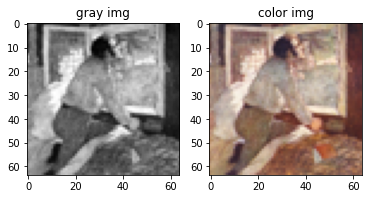

In [7]:
fig = plt.figure(figsize=(6,3))
rows = 1 
cols = 2

for X in train_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)), 0, 1), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

데이터 로더가 제대로 구성되어 흑백 이미지와 컬러 이미지가 잘 출력되고 있습니다. 단, 이미지 사이즈가 너무 작으면 해상도가 매우 낮을 수 있으니 적절한 이미지 사이즈를 설정해주어야 합니다.

마찬가지로 테스트 데이터 로더도 만들어주어 시각화해보겠습니다.

In [8]:
test_loader = DataLoader(
    victorianDataset(test_root, transforms_=transforms_),
    batch_size=test_batch_size,
    shuffle=True
)

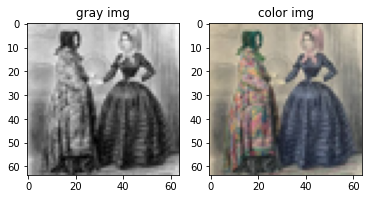

In [9]:
fig = plt.figure(figsize=(6,3))
rows = 1 
cols = 2

for X in test_loader:
    
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(np.clip(np.transpose(X["A"][0], (1,2,0)), 0, 1), cmap="gray")
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(np.clip(np.transpose(X["B"][0], (1,2,0)), 0, 1))
    ax2.set_title('color img')    

    plt.show()
    break

## 3.3 모델 구축

GAN 모델은 생성 모델(Generator)과 판별 모델(Descriminator)로 이루어져 있습니다. 각각은 `Conv2d`와 `ConvTranspose2d`, `MaxPool2d`, 정규화, 활성화함수들로 이루어져 있습니다. 

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        # batch_size * 2 * 64 * 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * 64 * 64 * 64
        self.maxpool = nn.MaxPool2d(2,2)
        
        # batch_size * 64 * 32 * 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 2) * 32 * 32
        # maxpool(2,2)
        
        # batch_size * (64 * 2) * 16 * 16
        self.conv3 = nn.Sequential(
            nn.Conv2d(64*2, 64 * 4, 3, 1, 1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 4) * 16 * 16
        # maxpool(2,2)
        
        # batch_size * (64 * 4) * 8 * 8
        self.conv4 = nn.Sequential(
            nn.Conv2d(64 * 4, 64 * 8, 8, 1, 0),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 8) * 1 * 1
        self.fc = nn.ConvTranspose2d(64 * 8, 64 * 16, 4, 1, 0)
        
        # batch_size * (64 * 16) * 4 * 4
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 8) * 8 * 8
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 4) * 16 * 16
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1),
            nn.BatchNorm2d(64 *2),
            nn.LeakyReLU(0.1)
        )
        
        # batch_size * (64 * 2) * 32 * 32        
        self.upsample4 = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        # batch_size * 64 * 64 * 64
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        
        # batch_size * 64 * 64 * 64
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
        # batch_size * 3 * 64 * 64

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        pool2 = self.maxpool(output2)
        output3 = self.conv3(pool2)
        pool3 = self.maxpool(output3)
        output4 = self.conv4(pool3)
        output5 = self.fc(output4)
        output6 = self.upsample1(output5)
        output7 = self.upsample2(output6) + output3
        output8 = self.upsample3(output7) + output2
        output9 = self.upsample4(output8) + output1
        output10 = self.conv1by1(output9)
        out = self.conv(output10)
        
        return out

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #""" color imgage (fake or real image)"""
            # batch_size * 3 * 64 * 64
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 64 * 32 * 32
            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch _size * 64 * 32 * 32
            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 128 * 16 * 16
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 256 * 8 * 8
            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 512 * 4 * 4
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            
            # batch_size * 1024 * 2 * 2
            )
        
        
        # batch_size * 1024 * 2 * 2
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )
        
    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

학습시 배치마다 가중치를 초기화 시켜주어야 합니다. 따라서 `weights_init` 함수를 만들어 생성 모델(Generator)과 판별 모델(Descriminator)에 붙여줍니다. 그리고 GPU에서 학습을 하기 위해서는 `.cuda(gpu)`를 통해 모델을 전달해줍니다. 출력되는 것을 통해 모델 구조를 확인할 수 있습니다.

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(8, 8), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope

In [14]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

## 3.4 모델 학습

이제 구축된 모델을 학습시켜보겠습니다. 학습 횟수는 100으로 지정하고, 생성모델과 판별모델 모두 Adam 최적화 방법을 사용해보겠습니다. 각 하이퍼파라미터는 튜닝하여 다양한 실험을 해볼 수 있습니다. 

학습은 판별모델, 생성모델 순으로 진행됩니다. 판별모델에서는 컬러 이미지를 진짜(real)로 흑백 이미지를 가짜(fake)로 인식하도록 학습을 하고, 생성모델에서는 흑백 이미지를 넣어 판별모델을 속일 수 있는 컬러 이미지를 생성하도록 학습됩니다.

In [14]:
max_epoch = 100
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

[Epoch 10/100] [Batch 13/13] [D loss: 0.559341] [G loss: 0.320948]


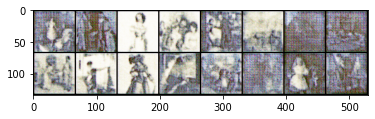

[Epoch 20/100] [Batch 13/13] [D loss: 0.480970] [G loss: 0.336876]


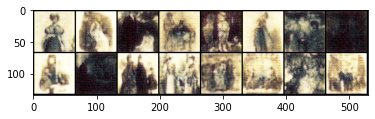

[Epoch 30/100] [Batch 13/13] [D loss: 0.488243] [G loss: 0.575131]


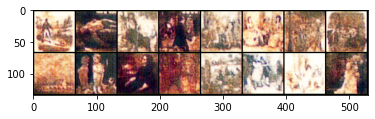

[Epoch 40/100] [Batch 13/13] [D loss: 0.542528] [G loss: 0.509518]


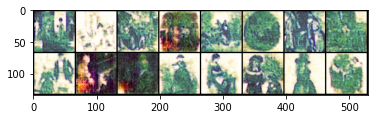

[Epoch 50/100] [Batch 13/13] [D loss: 0.368887] [G loss: 0.793681]


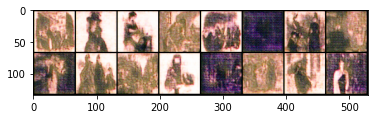

[Epoch 60/100] [Batch 13/13] [D loss: 0.610108] [G loss: 0.576743]


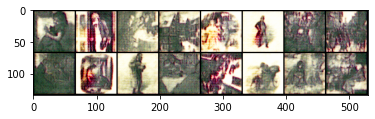

[Epoch 70/100] [Batch 13/13] [D loss: 0.019043] [G loss: 0.939426]


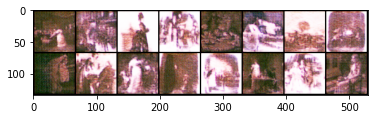

[Epoch 80/100] [Batch 13/13] [D loss: 0.410929] [G loss: 0.641025]


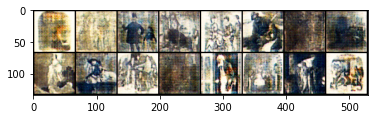

[Epoch 90/100] [Batch 13/13] [D loss: 0.146641] [G loss: 0.920925]


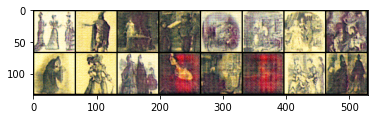

[Epoch 100/100] [Batch 13/13] [D loss: 0.247353] [G loss: 0.821513]


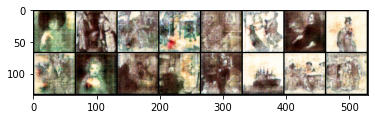

In [15]:
for epoch in range(max_epoch):
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        gray, color = data['A'], data['B']
        b_size = len(data['A'])

        color = torch.from_numpy(np.resize(color.numpy(), (b_size, 3, 64, 64))) 
        grays = torch.from_numpy(np.resize(gray.numpy(), (b_size, 1, 64, 64)))  # gray >> grays (batch_size * 1 * 64 * 64)


        ######## 판별모델(Discriminator) 학습 ########
        ######## Train Discriminator ########
        color = Variable(color.cuda(gpu))
        noise = torch.randn(b_size, 1, 64, 64).uniform_(0,1)   
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))   


        ######## 판별모델이 컬러 이미지를 진짜(real)로 인식하도록 학습 ########
        ######## Train d to recognize color image as real ########
        output = Discri(color,b_size)
        real_loss = torch.mean((output-1)**2)
        

        ######## 판별모델이 흑백 이미지를 가짜(fake)로 인식하도록 학습 ########
        ######## Train d to recognize fake image as fake ########        
        fake_img = Gener(gray_noise)   
        output = Discri(fake_img,b_size)
        fake_loss = torch.mean(output**2)
        

        ######## 역전파 & 판별모델 최적화 ########
        ######## Backpropagation & Optimize D ########
        d_loss = real_loss + fake_loss
        Discri.zero_grad()
        Gener.zero_grad()
        d_loss.backward()
        optimizerD.step()
        

        ######## 생성모델(Generator) 학습 ########
        ######## Train Generator ########
        noise = torch.randn(b_size, 1, 64, 64).uniform_(0,1)
        gray_noise2 = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))
        fake_img = Gener(gray_noise2)
        output = Discri(fake_img,b_size)
        g_loss = torch.mean((output-1)**2)
        

        ######## 역전파 & 생성모델 최적화 ########
        ######## Backpropagation & Optimize G ########
        Discri.zero_grad()
        Gener.zero_grad()
        g_loss.backward()
        optimizerG.step()


        fake_img = torchvision.utils.make_grid(fake_img.data)       
      
    if (epoch + 1) % 10 == 0:
        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item()))
        plt.imshow(np.clip(fake_img.cpu().numpy().transpose((1,2,0)), 0, 1))
        plt.show()

10에폭마다 각 모델의 로스값과 생성모델에서 흑백 이미지로 생성한 이미지를 출력합니다. 판별모델의 로스는 점점 감소하고, 생성모델의 로스는 점점 증가하는 것을 보아 제대로 학습이 되고 있는 것을 확인할 수 있습니다. 또한, 생성한 이미지를 보면 단조로운 색이 점점 다양하게 칠해지는 것을 확인할 수 있습니다.

## 3.5 예측 및 성능 평가

학습이 끝났으니 새로운 흑백 이미지에 적용하여 컬러 이미지로 예측(채색)해보도록 하겠습니다. 테스트 데이터 로더에는 총 6장의 이미지가 존재하며 각각의 이미지를 생성모델에 넣어 예측하게 됩니다.

======inputs======


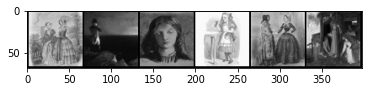

======target======


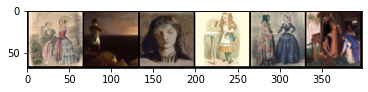

======output======


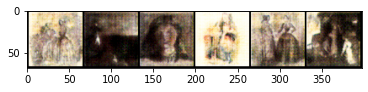

In [17]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, 64, 64).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, 64, 64)))    
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).cuda(gpu))
    
    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('======inputs======')
    plt.imshow(np.clip(inputs.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()
    print('======target======')
    plt.imshow(np.clip(labels.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()
    print('======output======')
    plt.imshow(np.clip(out.cpu().numpy().transpose((1,2,0)), 0, 1))
    plt.show()

예측 결과는 흑백, 컬러(타겟), 생성된 이미지(output)순으로 출력되어집니다. 해상도가 낮아 예측결과가 선명하진 않지만 타켓과 비슷한 색감을 갖도록 생성된 것을 볼 수 있습니다.

정량적인 성능 평가를 위해 ~~~값을 구해보도록 하겠습니다.

지금까지 3장에서 흑백 이미지를 컬러 이미지로 바꾸는 생성모델 GAN을 구축해보았습니다. 다음 장에서는 채색에 더 특화되어있는 pix2pix모델을 사용하여 비교해보도록 하겠습니다.